In [1]:
# DEPENDENCIES
import copy #Allows us to create copies of objects in memory
import math #Math functionality
import numpy as np #Numpy for working with arrays
import matplotlib.pyplot as plt #Plotting functionality

# Test Question 1

![img1.png](attachment:img1.png)

## Structure Data Entry

In [2]:
#=================================START OF DATA ENTRY================================
#Constants
E = 200*10**9 #(N/m^2)
A = 0.005 #(m^2)
xFac = 500 #Scale factor for plotted displacements

#Nodal coordinates [x, y] (in ascending node order)
nodes = np.array([[0,6],
                  [4,6],
                  [8,6],
                  [12,6],
                  [16,6],
                  [12,2],
                  [8,0],
                  [4,2]
                 ])

#Members [node_i, node_j]
members = np.array([[1,2],
                   [2,3],
                   [3,4],
                   [4,5],
                   [5,6],
                   [6,7],
                   [7,8],
                   [1,8],
                   [2,8],
                   [3,7],
                   [4,6],
                   [3,8],
                   [3,6]
                   ])

#Supports
restrainedDoF = [1,2,10] #The degrees of freedom restrained by supports


#Loading
forceVector = np.array([np.zeros(16)]).T
forceVector[3] = -10000
forceVector[5] = -30000
forceVector[7] = -5000
#=================================END OF DATA ENTRY================================

## Plot structure to confirm before proceeding

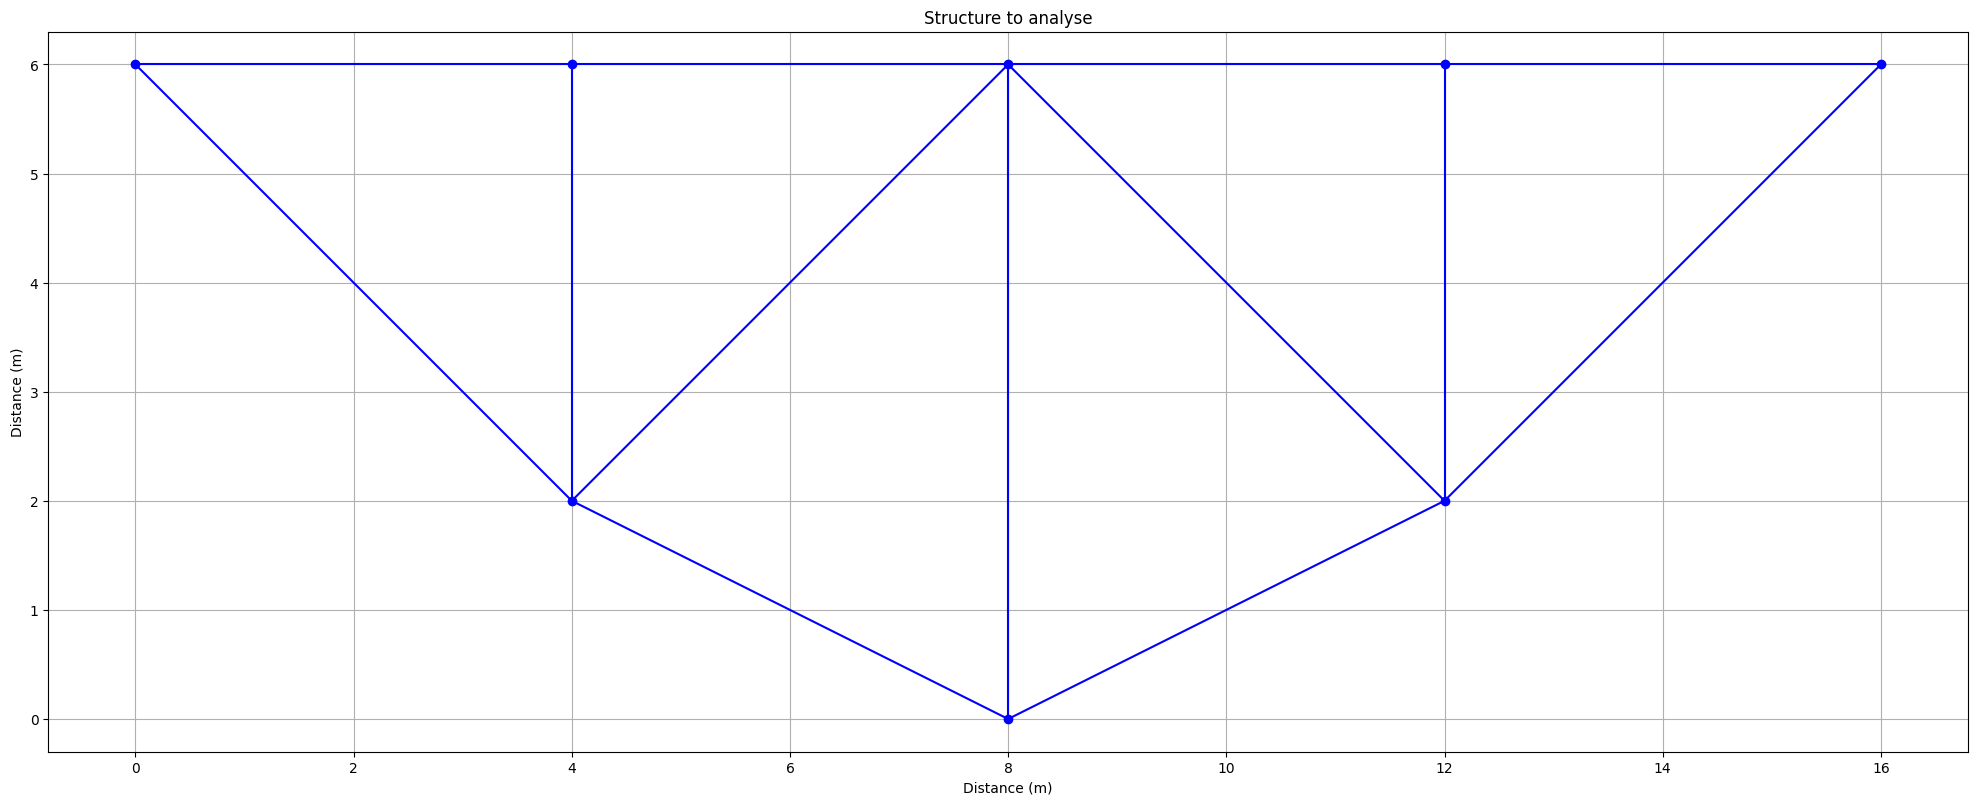

In [3]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,3,3])
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for mbr in members:
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member

    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member

    axes.plot([ix,jx],[iy,jy],'b') #Member

#Plot nodes
for node in nodes:
    axes.plot([node[0]],[node[1]],'bo')

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Structure to analyse')
axes.grid()
plt.show()

## Calculate member orientation and length

In [4]:
#Define a function to calculate member orientation and length
def memberOrientation(memberNo):
    memberIndex = memberNo-1 #Index identifying member in array of members
    node_i = members[memberIndex][0] #Node number for node i of this member
    node_j = members[memberIndex][1] #Node number for node j of this member

    xi = nodes[node_i-1][0] #x-coord for node i
    yi = nodes[node_i-1][1] #y-coord for node i
    xj = nodes[node_j-1][0] #x-coord for node j
    yj = nodes[node_j-1][1] #y-coord for node j

    #Angle of member with respect to horizontal axis

    dx = xj-xi #x-component of vector along member
    dy = yj-yi #y-component of vector along member
    mag = math.sqrt(dx**2 + dy**2) #Magnitude of vector (length of member)
    memberVector = np.array([dx,dy])#Member represented as a vector

    #Need to capture quadrant first then appropriate reference axis and offset angle
    if(dx>0 and dy==0):
        theta = 0
    elif(dx==0 and dy>0):
        theta = math.pi/2
    elif(dx<0 and dy==0):
        theta = math.pi
    elif(dx==0 and dy<0):
        theta = 3*math.pi/2
    elif(dx>0 and dy>0):
        # 0<theta<90
        refVector = np.array([1,0]) # Vector describing the positive x-axis
        theta = math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors
    elif(dx<0 and dy>0):
        # 90<theta<180
        refVector = np.array([0,1]) # Vector describing the positive y-axis
        theta = (math.pi/2) + math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors
    elif(dx<0 and dy<0):
        # 180<theta<270
        refVector = np.array([-1,0]) # Vector describing the negative x-axis
        theta = math.pi + math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors
    else:
        # 270<theta<360
        refVector = np.array([0,-1]) # Vector describing the negative y-axis
        theta = (3*math.pi/2) + math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors

    return [theta, mag]

In [5]:
#Calculate orientation and length for each member and store
orientations = np.array([])#Initialise an array to hold orientations
lengths = np.array([]) #Initialise an array to hold lengths
for n, mbr in enumerate(members):
    [angle, length] = memberOrientation(n+1)
    orientations = np.append(orientations,angle)
    lengths = np.append(lengths,length)

## Define a function to calculate member global stiffness matrix

In [7]:
#Define a function to calculate the global stiffness matrix of an axially loaded bar
def calculateKg(memberNo):
    """
    Calculate the global stiffness matrix for an axially loaded bar
    memberNo: The member number
    """
    theta = orientations[memberNo-1]
    mag = lengths[memberNo-1]

    c = math.cos(theta)
    s = math.sin(theta)

    K11 = (E*A/mag)*np.array([[c**2,c*s],[c*s,s**2]]) #Top left quadrant of global stiffness matrix
    K12 = (E*A/mag)*np.array([[-c**2,-c*s],[-c*s,-s**2]]) #Top right quadrant of global stiffness matrix
    K21 = (E*A/mag)*np.array([[-c**2,-c*s],[-c*s,-s**2]]) #Bottom left quadrant of global stiffness matrix
    K22 = (E*A/mag)*np.array([[c**2,c*s],[c*s,s**2]]) #Bottom right quadrant of global stiffness matrix

    return [K11, K12, K21,K22]

## Build the primary stiffness matrix, Kp

In [8]:
nDoF = np.amax(members)*2 #Total number of degrees of freedom in the problem
Kp = np.zeros([nDoF,nDoF]) #Initialise the primary stiffness matrix

for n, mbr in enumerate(members):
#note that enumerate adds a counter to an iterable (n)

    #Calculate the quadrants of the global stiffness matrix for the member
    [K11, K12, K21,K22] = calculateKg(n+1)

    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    #Primary stiffness matrix indices associated with each node
    #i.e. node 1 occupies indices 0 and 1 (accessed in Python with [0:2])
    ia = 2*node_i-2 #index 0
    ib = 2*node_i-1 #index 1
    ja = 2*node_j-2 #index 2
    jb = 2*node_j-1 #index 3
    Kp[ia:ib+1,ia:ib+1] = Kp[ia:ib+1,ia:ib+1] + K11
    Kp[ia:ib+1,ja:jb+1] = Kp[ia:ib+1,ja:jb+1] + K12
    Kp[ja:jb+1,ia:ib+1] = Kp[ja:jb+1,ia:ib+1] + K21
    Kp[ja:jb+1,ja:jb+1] = Kp[ja:jb+1,ja:jb+1] + K22

## Extract structure stiffness matrix, Ks

In [9]:
restrainedIndex = [x - 1 for x in restrainedDoF] #Index for each restrained DoF (list comprehension)

#Reduce to structure stiffness matrix by deleting rows and columns for restrained DoF
Ks = np.delete(Kp,restrainedIndex,0) #Delete rows
Ks = np.delete(Ks,restrainedIndex,1) #Delete columns
Ks = np.matrix(Ks) # Convert Ks from numpy.ndarray to numpy.matrix to use build in inverter function

## Solve for displacements

In [10]:
forceVectorRed = copy.copy(forceVector)# Make a copy of forceVector so the copy can be edited, leaving the original unchanged
forceVectorRed = np.delete(forceVectorRed,restrainedIndex,0) #Delete rows corresponding to restrained DoF
U = Ks.I*forceVectorRed

## Solve for reactions

In [11]:
#Construct the global displacement vector
UG = np.zeros(nDoF) #Initialise an array to hold the global displacement vector
c=0 #Initialise a counter to track how many restraints have been imposed
for i in np.arange(nDoF):
    if i in restrainedIndex:
        #Impose zero displacement
        UG[i] = 0
    else:
        #Assign actual displacement
        UG[i] = U[c]
        c=c+1

UG = np.array([UG]).T
FG = np.matmul(Kp,UG)

#Generate output statements
for i in np.arange(0,len(restrainedIndex)):
    index = restrainedIndex[i]

## Solve for member forces

In [12]:
mbrForces = np.array([]) #Initialise an array to hold member forces
for n, mbr in enumerate(members):
    theta = orientations[n]
    mag = lengths[n]

    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member
    #Primary stiffness matrix indices associated with each node
    ia = 2*node_i-2
    ib = 2*node_i-1
    ja = 2*node_j-2
    jb = 2*node_j-1

    #Transformation matrix
    c = math.cos(theta)
    s = math.sin(theta)
    T = np.array([[c,s,0,0],[0,0,c,s]])

    disp = np.array([[UG[ia],UG[ib],UG[ja],UG[jb]]]).T #Glocal displacements
    disp_local = np.matmul(T,disp)[0] #Local displacements
    F_axial = (A*E/mag)*(disp_local[1]-disp_local[0]) #Axial loads
    mbrForces = np.append(mbrForces,F_axial) #Store axial loads

## Plotting

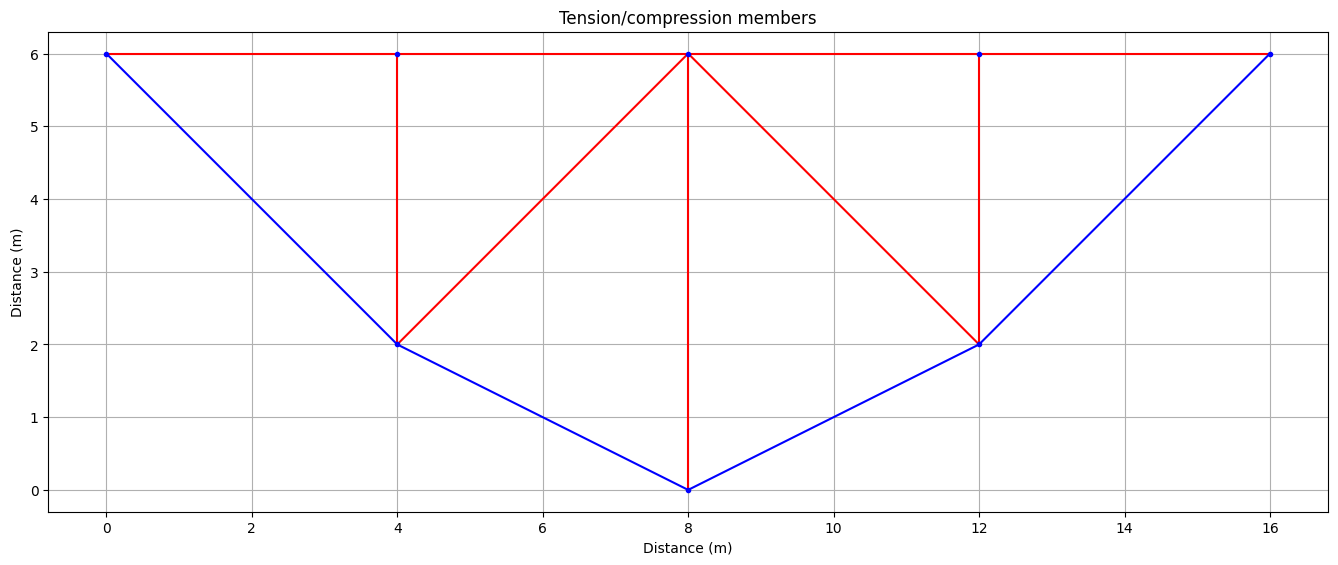

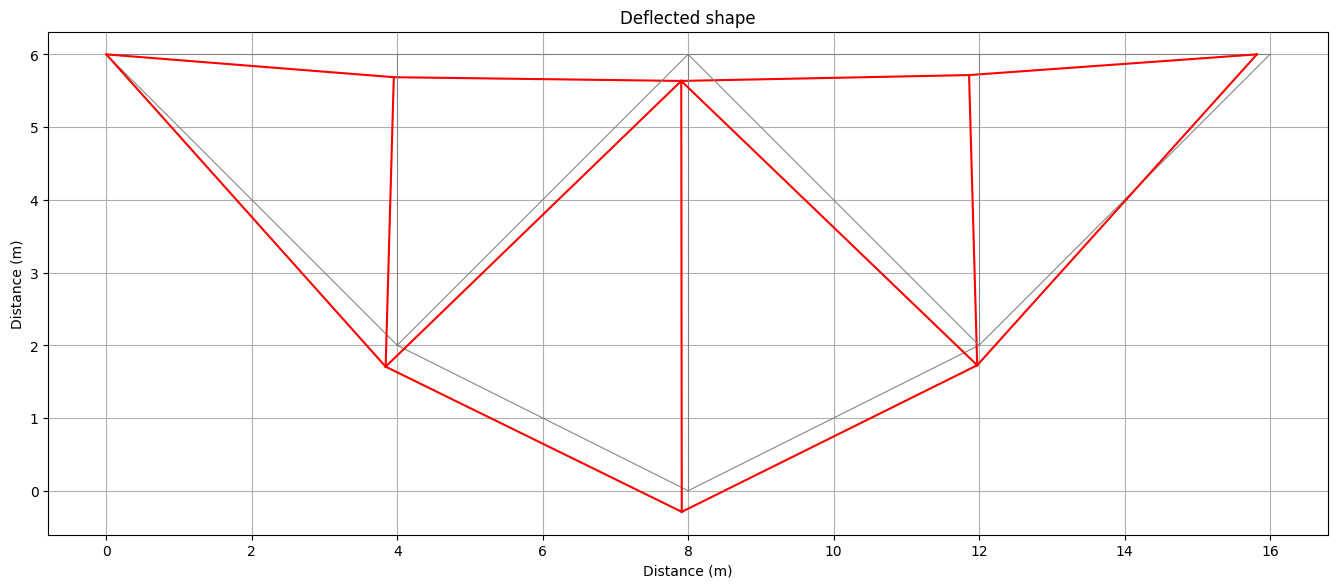

In [13]:
#FIGURE TO PLOT TENSION/COMPRESSION MEMBERS
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for n, mbr in enumerate(members):
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member

    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member

    if(abs(mbrForces[n])<0.001):
        axes.plot([ix,jx],[iy,jy],'grey',linestyle='--') #Zero force in member
    elif(mbrForces[n]>0):
        axes.plot([ix,jx],[iy,jy],'b') #Member in tension
    else:
        axes.plot([ix,jx],[iy,jy],'r') #Member in compression

#Plot nodes
for node in nodes:
    axes.plot([node[0]],[node[1]],'bo', ms=3)

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Tension/compression members')
axes.grid()
plt.show()

#=========================================================================

#FIGURE TO PLOT DEFLECTED SHAPE
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for mbr in members:
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member

    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member

    axes.plot([ix,jx],[iy,jy],'grey', lw=0.75) #Member
    axes.plot([ix + UG[ia,0]*xFac, jx + UG[ja,0]*xFac], [iy + UG[ib,0]*xFac, jy + UG[jb,0]*xFac],'r') #Deformed member

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Deflected shape')
axes.grid()
plt.show()

## Summary output

In [39]:
#Generate output statements
print("REACTIONS")
for i in np.arange(0,len(restrainedIndex)):
    index = restrainedIndex[i]
    print("Reaction at DoF {one}: {two} kN".format(one = index+1, two = round(FG[index].item()/1000,2)))

print("")
print("MEMBER FORCES")
for n, mbr in enumerate(members):
    print("Force in member {one} (nodes {two} to {three}) is {four} kN".format(one = n+1, two=mbr[0], three=mbr[1], four=round(mbrForces[n]/1000,2)))

print("")
print("NODAL DISPLACEMENTS")
for n, node in enumerate(nodes):
    ix = 2*(n+1)-2 #horizontal DoF for this node
    iy = 2*(n+1)-1 #vertical DoF for this node

    ux = round(UG[ix,0],5) #Horizontal nodal displacement
    uy = round(UG[iy,0],5) #Vertical nodal displacement
    print("Node {one}: Ux = {two} m, Uy = {three} m".format(one=n+1, two=ux, three=uy))

REACTIONS
Reaction at DoF 1: -125.01 kN
Reaction at DoF 2: -107.21 kN
Reaction at DoF 33: 125.08 kN
Reaction at DoF 34: -107.24 kN
Reaction at DoF 41: -931.49 kN
Reaction at DoF 42: 807.22 kN
Reaction at DoF 57: 931.42 kN
Reaction at DoF 58: 807.22 kN

MEMBER FORCES
Force in member 1 (nodes 1 to 2) is 65.6 kN
Force in member 2 (nodes 2 to 3) is 31.38 kN
Force in member 3 (nodes 3 to 4) is 202.09 kN
Force in member 4 (nodes 4 to 5) is 238.24 kN
Force in member 5 (nodes 5 to 6) is 238.24 kN
Force in member 6 (nodes 6 to 7) is 59.0 kN
Force in member 7 (nodes 7 to 8) is -253.58 kN
Force in member 8 (nodes 8 to 9) is -636.51 kN
Force in member 9 (nodes 9 to 10) is -636.65 kN
Force in member 10 (nodes 10 to 11) is -253.56 kN
Force in member 11 (nodes 11 to 12) is 58.84 kN
Force in member 12 (nodes 12 to 13) is 238.3 kN
Force in member 13 (nodes 13 to 14) is 238.3 kN
Force in member 14 (nodes 14 to 15) is 202.16 kN
Force in member 15 (nodes 15 to 16) is 31.67 kN
Force in member 16 (nodes 16 

# Test Question 2

![img1.png](attachment:img1.png)

## Structure Data Entry

In [15]:
#=================================START OF DATA ENTRY================================
#Constants
E = 200*10**9 #(N/m^2)
A = 0.005 #(m^2)
xFac = 5 #Scale factor for plotted displacements

#Nodal coordinates [x, y] (in ascending node order)
nodes = np.array([[0,0],
                  [10,10],
                  [20,8.333],
                  [30,6.667],
                  [40,5],
                  [50,3.333],
                  [60,1.667],
                  [70,3.333],
                  [80,1.667],
                  [90,3.333],
                  [100,5],
                  [110,6.667],
                  [120,8.333],
                  [130,10],
                  [140,0],
                  [130,0],
                  [120,0],
                  [110,0],
                  [100,0],
                  [90,0],
                  [80,0],
                  [70,0],
                  [60,0],
                  [50,0],
                  [40,0],
                  [30,0],
                  [20,0],
                  [10,0]])

#Members [node_i, node_j]
members = np.array([
                   #Perimeter members
                   [1,2],
                   [2,3],
                   [3,4],
                   [4,5],
                   [5,6],
                   [6,7],
                   [7,8],
                   [8,9],
                   [9,10],
                   [10,11],
                   [11,12],
                   [12,13],
                   [13,14],
                   [14,15],
                   [16,17],
                   [17,18],
                   [18,19],
                   [19,20],
                   [20,21],
                   [21,22],
                   [22,23],
                   [23,24],
                   [24,25],
                   [25,26],
                   [26,27],
                   [27,28],
                   #Vertical members
                   [2,28],
                   [3,27],
                   [4,26],
                   [5,25],
                   [6,24],
                   [7,23],
                   [8,22],
                   [9,21],
                   [10,20],
                   [11,19],
                   [12,18],
                   [13,17],
                   [14,16],
                   #Diagonal members
                   [3,28],
                   [4,27],
                   [5,26],
                   [6,25],
                   [7,24],
                   [7,22],
                   [9,22],
                   [9,20],
                   [10,19],
                   [11,18],
                   [12,17],
                   [13,16],
                   ])

#Supports
restrainedDoF = [1,2,29,30,31,32,55,56] #The degrees of freedom restrained by supports


#Loading
forceVector = np.array([np.zeros(56)]).T
forceVector[33] = -40000
forceVector[35] = -40000
forceVector[37] = -40000
forceVector[39] = -40000
forceVector[41] = -40000
forceVector[43] = -40000
forceVector[45] = -40000
forceVector[47] = -40000
forceVector[49] = -40000
forceVector[51] = -40000
forceVector[53] = -40000

#=================================END OF DATA ENTRY================================

## Plot structure to confirm before proceeding

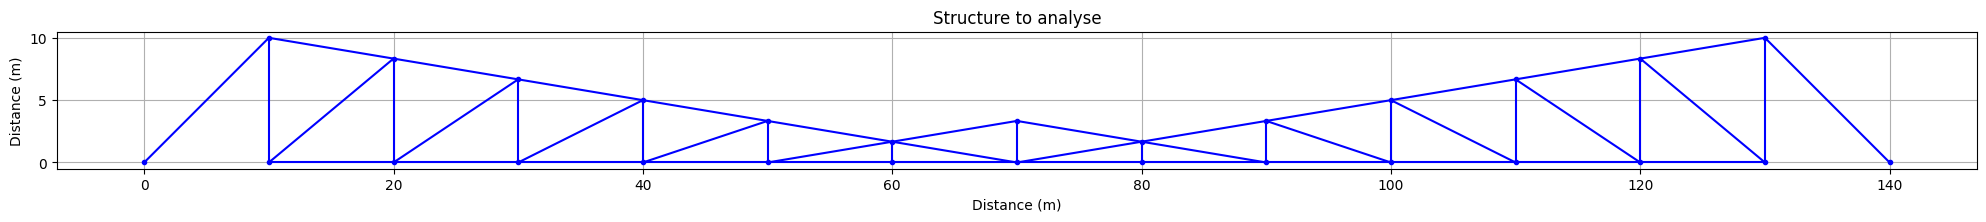

In [16]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,3,3])
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for mbr in members:
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member

    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member

    axes.plot([ix,jx],[iy,jy],'b') #Member

#Plot nodes
for node in nodes:
    axes.plot([node[0]],[node[1]],'bo',ms=3)

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Structure to analyse')
axes.grid()
plt.show()

## Calculate member orientation and length

In [17]:
#Define a function to calculate member orientation and length
def memberOrientation(memberNo):
    memberIndex = memberNo-1 #Index identifying member in array of members
    node_i = members[memberIndex][0] #Node number for node i of this member
    node_j = members[memberIndex][1] #Node number for node j of this member

    xi = nodes[node_i-1][0] #x-coord for node i
    yi = nodes[node_i-1][1] #y-coord for node i
    xj = nodes[node_j-1][0] #x-coord for node j
    yj = nodes[node_j-1][1] #y-coord for node j

    #Angle of member with respect to horizontal axis

    dx = xj-xi #x-component of vector along member
    dy = yj-yi #y-component of vector along member
    mag = math.sqrt(dx**2 + dy**2) #Magnitude of vector (length of member)
    memberVector = np.array([dx,dy])#Member represented as a vector

    #Need to capture quadrant first then appropriate reference axis and offset angle
    if(dx>0 and dy==0):
        theta = 0
    elif(dx==0 and dy>0):
        theta = math.pi/2
    elif(dx<0 and dy==0):
        theta = math.pi
    elif(dx==0 and dy<0):
        theta = 3*math.pi/2
    elif(dx>0 and dy>0):
        # 0<theta<90
        refVector = np.array([1,0]) # Vector describing the positive x-axis
        theta = math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors
    elif(dx<0 and dy>0):
        # 90<theta<180
        refVector = np.array([0,1]) # Vector describing the positive y-axis
        theta = (math.pi/2) + math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors
    elif(dx<0 and dy<0):
        # 180<theta<270
        refVector = np.array([-1,0]) # Vector describing the negative x-axis
        theta = math.pi + math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors
    else:
        # 270<theta<360
        refVector = np.array([0,-1]) # Vector describing the negative y-axis
        theta = (3*math.pi/2) + math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors

    return [theta, mag]

In [18]:
#Calculate orientation and length for each member and store
orientations = np.array([])#Initialise an array to hold orientations
lengths = np.array([]) #Initialise an array to hold lengths
for n, mbr in enumerate(members):
    [angle, length] = memberOrientation(n+1)
    orientations = np.append(orientations,angle)
    lengths = np.append(lengths,length)

## Define a function to calculate member global stiffness matrix

In [19]:
#Define a function to calculate the global stiffness matrix of an axially loaded bar
def calculateKg(memberNo):
    """
    Calculate the global stiffness matrix for an axially loaded bar
    memberNo: The member number
    """
    theta = orientations[memberNo-1]
    mag = lengths[memberNo-1]

    c = math.cos(theta)
    s = math.sin(theta)

    K11 = (E*A/mag)*np.array([[c**2,c*s],[c*s,s**2]]) #Top left quadrant of global stiffness matrix
    K12 = (E*A/mag)*np.array([[-c**2,-c*s],[-c*s,-s**2]]) #Top right quadrant of global stiffness matrix
    K21 = (E*A/mag)*np.array([[-c**2,-c*s],[-c*s,-s**2]]) #Bottom left quadrant of global stiffness matrix
    K22 = (E*A/mag)*np.array([[c**2,c*s],[c*s,s**2]]) #Bottom right quadrant of global stiffness matrix

    return [K11, K12, K21,K22]

## Build the primary stiffness matrix, Kp

In [20]:
nDoF = np.amax(members)*2 #Total number of degrees of freedom in the problem
Kp = np.zeros([nDoF,nDoF]) #Initialise the primary stiffness matrix

for n, mbr in enumerate(members):
#note that enumerate adds a counter to an iterable (n)

    #Calculate the quadrants of the global stiffness matrix for the member
    [K11, K12, K21,K22] = calculateKg(n+1)

    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    #Primary stiffness matrix indices associated with each node
    #i.e. node 1 occupies indices 0 and 1 (accessed in Python with [0:2])
    ia = 2*node_i-2 #index 0
    ib = 2*node_i-1 #index 1
    ja = 2*node_j-2 #index 2
    jb = 2*node_j-1 #index 3
    Kp[ia:ib+1,ia:ib+1] = Kp[ia:ib+1,ia:ib+1] + K11
    Kp[ia:ib+1,ja:jb+1] = Kp[ia:ib+1,ja:jb+1] + K12
    Kp[ja:jb+1,ia:ib+1] = Kp[ja:jb+1,ia:ib+1] + K21
    Kp[ja:jb+1,ja:jb+1] = Kp[ja:jb+1,ja:jb+1] + K22

## Extract structure stiffness matrix, Ks

In [21]:
restrainedIndex = [x - 1 for x in restrainedDoF] #Index for each restrained DoF (list comprehension)

#Reduce to structure stiffness matrix by deleting rows and columns for restrained DoF
Ks = np.delete(Kp,restrainedIndex,0) #Delete rows
Ks = np.delete(Ks,restrainedIndex,1) #Delete columns
Ks = np.matrix(Ks) # Convert Ks from numpy.ndarray to numpy.matrix to use build in inverter function

## Solve for displacements

In [22]:
forceVectorRed = copy.copy(forceVector)# Make a copy of forceVector so the copy can be edited, leaving the original unchanged
forceVectorRed = np.delete(forceVectorRed,restrainedIndex,0) #Delete rows corresponding to restrained DoF
U = Ks.I*forceVectorRed

## Solve for reactions

In [23]:
#Construct the global displacement vector
UG = np.zeros(nDoF) #Initialise an array to hold the global displacement vector
c=0 #Initialise a counter to track how many restraints have been imposed
for i in np.arange(nDoF):
    if i in restrainedIndex:
        #Impose zero displacement
        UG[i] = 0
    else:
        #Assign actual displacement
        UG[i] = U[c]
        c=c+1

UG = np.array([UG]).T
FG = np.matmul(Kp,UG)

#Generate output statements
for i in np.arange(0,len(restrainedIndex)):
    index = restrainedIndex[i]

## Solve for member forces

In [24]:
mbrForces = np.array([]) #Initialise an array to hold member forces
for n, mbr in enumerate(members):
    theta = orientations[n]
    mag = lengths[n]

    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member
    #Primary stiffness matrix indices associated with each node
    ia = 2*node_i-2
    ib = 2*node_i-1
    ja = 2*node_j-2
    jb = 2*node_j-1

    #Transformation matrix
    c = math.cos(theta)
    s = math.sin(theta)
    T = np.array([[c,s,0,0],[0,0,c,s]])

    disp = np.array([[UG[ia],UG[ib],UG[ja],UG[jb]]]).T #Glocal displacements
    disp_local = np.matmul(T,disp)[0] #Local displacements
    F_axial = (A*E/mag)*(disp_local[1]-disp_local[0]) #Axial loads
    mbrForces = np.append(mbrForces,F_axial) #Store axial loads

## Plotting

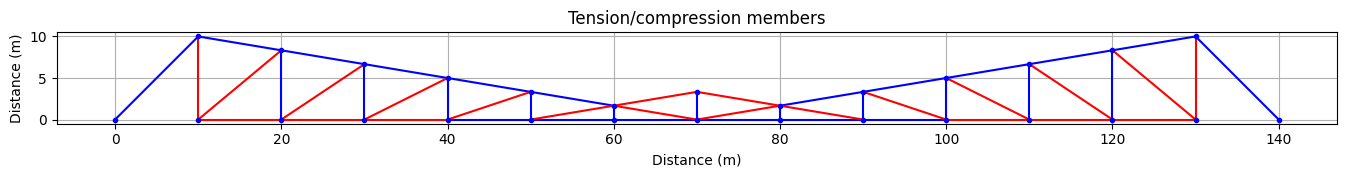

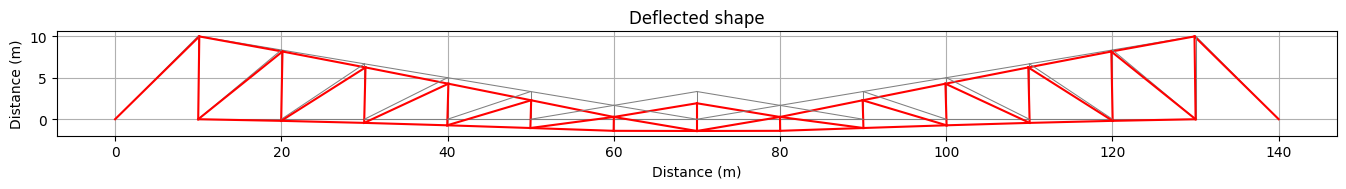

In [25]:
#FIGURE TO PLOT TENSION/COMPRESSION MEMBERS
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for n, mbr in enumerate(members):
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member

    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member

    if(abs(mbrForces[n])<0.001):
        axes.plot([ix,jx],[iy,jy],'grey',linestyle='--') #Zero force in member
    elif(mbrForces[n]>0):
        axes.plot([ix,jx],[iy,jy],'b') #Member in tension
    else:
        axes.plot([ix,jx],[iy,jy],'r') #Member in compression

#Plot nodes
for node in nodes:
    axes.plot([node[0]],[node[1]],'bo', ms=3)

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Tension/compression members')
axes.grid()
plt.show()

#=========================================================================

#FIGURE TO PLOT DEFLECTED SHAPE
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for mbr in members:
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member

    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member

    axes.plot([ix,jx],[iy,jy],'grey', lw=0.75) #Member
    axes.plot([ix + UG[ia,0]*xFac, jx + UG[ja,0]*xFac], [iy + UG[ib,0]*xFac, jy + UG[jb,0]*xFac],'r') #Deformed member

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Deflected shape')
axes.grid()
plt.show()

## Summary output

In [26]:
#Generate output statements
print("REACTIONS")
for i in np.arange(0,len(restrainedIndex)):
    index = restrainedIndex[i]
    print("Reaction at DoF {one}: {two} kN".format(one = index+1, two = round(FG[index].item()/1000,2)))

print("")
print("MEMBER FORCES")
for n, mbr in enumerate(members):
    print("Force in member {one} (nodes {two} to {three}) is {four} kN".format(one = n+1, two=mbr[0], three=mbr[1], four=round(mbrForces[n]/1000,2)))

print("")
print("NODAL DISPLACEMENTS")
for n, node in enumerate(nodes):
    ix = 2*(n+1)-2 #horizontal DoF for this node
    iy = 2*(n+1)-1 #vertical DoF for this node

    ux = round(UG[ix,0],5) #Horizontal nodal displacement
    uy = round(UG[iy,0],5) #Vertical nodal displacement
    print("Node {one}: Ux = {two} m, Uy = {three} m".format(one=n+1, two=ux, three=uy))

REACTIONS
Reaction at DoF 1: -662.98 kN
Reaction at DoF 2: -662.98 kN
Reaction at DoF 29: 662.98 kN
Reaction at DoF 30: -662.98 kN
Reaction at DoF 31: -530.19 kN
Reaction at DoF 32: 882.98 kN
Reaction at DoF 55: 530.19 kN
Reaction at DoF 56: 882.98 kN

MEMBER FORCES
Force in member 1 (nodes 1 to 2) is 937.59 kN
Force in member 2 (nodes 2 to 3) is 672.13 kN
Force in member 3 (nodes 3 to 4) is 538.92 kN
Force in member 4 (nodes 4 to 5) is 399.89 kN
Force in member 5 (nodes 5 to 6) is 249.35 kN
Force in member 6 (nodes 6 to 7) is 69.89 kN
Force in member 7 (nodes 7 to 8) is -173.44 kN
Force in member 8 (nodes 8 to 9) is -173.44 kN
Force in member 9 (nodes 9 to 10) is 69.89 kN
Force in member 10 (nodes 10 to 11) is 249.35 kN
Force in member 11 (nodes 11 to 12) is 399.89 kN
Force in member 12 (nodes 12 to 13) is 538.92 kN
Force in member 13 (nodes 13 to 14) is 672.13 kN
Force in member 14 (nodes 14 to 15) is 937.59 kN
Force in member 15 (nodes 16 to 17) is -398.8 kN
Force in member 16 (node

# Test Question 3

![img1.png](attachment:img1.png)

## Structure Data Entry

In [27]:
#=================================START OF DATA ENTRY================================
#Constants
E = 200*10**9 #(N/m^2)
A = 0.005 #(m^2)
xFac = 50 #Scale factor for plotted displacements

#Nodal coordinates [x, y] (in ascending node order)
nodes = np.array([[0,0],
                  [9.804,18],
                  [20,18],
                  [30.195,18],
                  [40,18],
                  [50.715,18],
                  [62.939,18],
                  [76.204,18],
                  [90,18],
                  [103.79,18],
                  [117.06,18],
                  [129.28,18],
                  [140,18],
                  [149.8,18],
                  [160,18],
                  [170.19,18],
                  [180,0],
                  [170.16,5.194],
                  [160,6.948],
                  [149.8,5.194],
                  [140,0],
                  [129.28,4.939],
                  [117.06,8.61],
                  [103.79,10.87],
                  [90,11.633],
                  [76.204,10.87],
                  [62.939,8.61],
                  [50.715,4.939],
                  [40,0],
                  [30.195,5.194],
                  [20,6.948],
                  [9.804,5.194]])

#Members [node_i, node_j]
members = np.array([
                   #Perimeter members
                   [1,2],
                   [2,3],
                   [3,4],
                   [4,5],
                   [5,6],
                   [6,7],
                   [7,8],
                   [8,9],
                   [9,10],
                   [10,11],
                   [11,12],
                   [12,13],
                   [13,14],
                   [14,15],
                   [15,16],
                   [16,17],
                   [17,18],
                   [18,19],
                   [19,20],
                   [20,21],
                   [21,22],
                   [22,23],
                   [23,24],
                   [24,25],
                   [25,26],
                   [26,27],
                   [27,28],
                   [28,29],
                   [29,30],
                   [30,31],
                   [31,32],
                   [32,1],
                   #Vertical members
                   [2,32],
                   [3,31],
                   [4,30],
                   [5,29],
                   [6,28],
                   [7,27],
                   [8,26],
                   [9,25],
                   [10,24],
                   [11,23],
                   [12,22],
                   [13,21],
                   [14,20],
                   [15,19],
                   [16,18],
                   #Diagonal members
                   [3,32],
                   [3,30],
                   [4,29],
                   [6,29],
                   [7,28],
                   [8,27],
                   [9,26],
                   [9,24],
                   [10,23],
                   [11,22],
                   [12,21],
                   [14,21],
                   [15,20],
                   [15,18],
                   ])

#Supports
restrainedDoF = [1,2,33,34,41,42,57,58] #The degrees of freedom restrained by supports

#Loading
forceVector = np.array([np.zeros(64)]).T
forceVector[11] = -200000
forceVector[13] = -200000
forceVector[15] = -200000
forceVector[17] = -200000
forceVector[19] = -200000
forceVector[21] = -200000
forceVector[23] = -200000

#=================================END OF DATA ENTRY================================

## Plot structure to confirm before proceeding

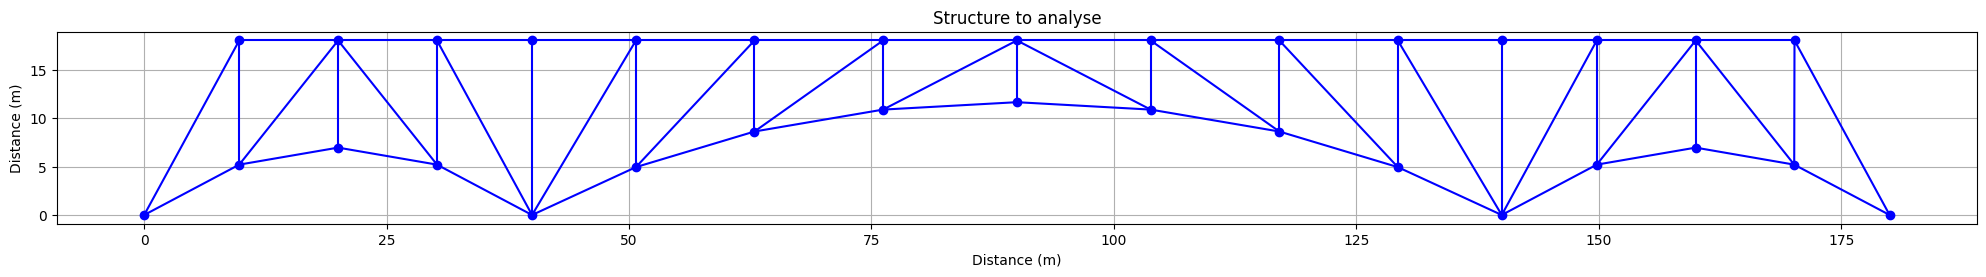

In [28]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,3,3])
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for mbr in members:
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member

    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member

    axes.plot([ix,jx],[iy,jy],'b') #Member

#Plot nodes
for node in nodes:
    axes.plot([node[0]],[node[1]],'bo')

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Structure to analyse')
axes.grid()
plt.show()

## Calculate member orientation and length

In [29]:
#Define a function to calculate member orientation and length
def memberOrientation(memberNo):
    memberIndex = memberNo-1 #Index identifying member in array of members
    node_i = members[memberIndex][0] #Node number for node i of this member
    node_j = members[memberIndex][1] #Node number for node j of this member

    xi = nodes[node_i-1][0] #x-coord for node i
    yi = nodes[node_i-1][1] #y-coord for node i
    xj = nodes[node_j-1][0] #x-coord for node j
    yj = nodes[node_j-1][1] #y-coord for node j

    #Angle of member with respect to horizontal axis

    dx = xj-xi #x-component of vector along member
    dy = yj-yi #y-component of vector along member
    mag = math.sqrt(dx**2 + dy**2) #Magnitude of vector (length of member)
    memberVector = np.array([dx,dy])#Member represented as a vector

    #Need to capture quadrant first then appropriate reference axis and offset angle
    if(dx>0 and dy==0):
        theta = 0
    elif(dx==0 and dy>0):
        theta = math.pi/2
    elif(dx<0 and dy==0):
        theta = math.pi
    elif(dx==0 and dy<0):
        theta = 3*math.pi/2
    elif(dx>0 and dy>0):
        # 0<theta<90
        refVector = np.array([1,0]) # Vector describing the positive x-axis
        theta = math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors
    elif(dx<0 and dy>0):
        # 90<theta<180
        refVector = np.array([0,1]) # Vector describing the positive y-axis
        theta = (math.pi/2) + math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors
    elif(dx<0 and dy<0):
        # 180<theta<270
        refVector = np.array([-1,0]) # Vector describing the negative x-axis
        theta = math.pi + math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors
    else:
        # 270<theta<360
        refVector = np.array([0,-1]) # Vector describing the negative y-axis
        theta = (3*math.pi/2) + math.acos(refVector.dot(memberVector)/(mag))#Standard formula for the angle between two vectors

    return [theta, mag]

In [30]:
#Calculate orientation and length for each member and store
orientations = np.array([])#Initialise an array to hold orientations
lengths = np.array([]) #Initialise an array to hold lengths
for n, mbr in enumerate(members):
    [angle, length] = memberOrientation(n+1)
    orientations = np.append(orientations,angle)
    lengths = np.append(lengths,length)

## Define a function to calculate member global stiffness matrix

In [31]:
#Define a function to calculate the global stiffness matrix of an axially loaded bar
def calculateKg(memberNo):
    """
    Calculate the global stiffness matrix for an axially loaded bar
    memberNo: The member number
    """
    theta = orientations[memberNo-1]
    mag = lengths[memberNo-1]

    c = math.cos(theta)
    s = math.sin(theta)

    K11 = (E*A/mag)*np.array([[c**2,c*s],[c*s,s**2]]) #Top left quadrant of global stiffness matrix
    K12 = (E*A/mag)*np.array([[-c**2,-c*s],[-c*s,-s**2]]) #Top right quadrant of global stiffness matrix
    K21 = (E*A/mag)*np.array([[-c**2,-c*s],[-c*s,-s**2]]) #Bottom left quadrant of global stiffness matrix
    K22 = (E*A/mag)*np.array([[c**2,c*s],[c*s,s**2]]) #Bottom right quadrant of global stiffness matrix

    return [K11, K12, K21,K22]

## Build the primary stiffness matrix, Kp

In [32]:
nDoF = np.amax(members)*2 #Total number of degrees of freedom in the problem
Kp = np.zeros([nDoF,nDoF]) #Initialise the primary stiffness matrix

for n, mbr in enumerate(members):
#note that enumerate adds a counter to an iterable (n)

    #Calculate the quadrants of the global stiffness matrix for the member
    [K11, K12, K21,K22] = calculateKg(n+1)

    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    #Primary stiffness matrix indices associated with each node
    #i.e. node 1 occupies indices 0 and 1 (accessed in Python with [0:2])
    ia = 2*node_i-2 #index 0
    ib = 2*node_i-1 #index 1
    ja = 2*node_j-2 #index 2
    jb = 2*node_j-1 #index 3
    Kp[ia:ib+1,ia:ib+1] = Kp[ia:ib+1,ia:ib+1] + K11
    Kp[ia:ib+1,ja:jb+1] = Kp[ia:ib+1,ja:jb+1] + K12
    Kp[ja:jb+1,ia:ib+1] = Kp[ja:jb+1,ia:ib+1] + K21
    Kp[ja:jb+1,ja:jb+1] = Kp[ja:jb+1,ja:jb+1] + K22

## Extract structure stiffness matrix, Ks

In [33]:
restrainedIndex = [x - 1 for x in restrainedDoF] #Index for each restrained DoF (list comprehension)

#Reduce to structure stiffness matrix by deleting rows and columns for restrained DoF
Ks = np.delete(Kp,restrainedIndex,0) #Delete rows
Ks = np.delete(Ks,restrainedIndex,1) #Delete columns
Ks = np.matrix(Ks) # Convert Ks from numpy.ndarray to numpy.matrix to use build in inverter function

## Solve for displacements

In [34]:
forceVectorRed = copy.copy(forceVector)# Make a copy of forceVector so the copy can be edited, leaving the original unchanged
forceVectorRed = np.delete(forceVectorRed,restrainedIndex,0) #Delete rows corresponding to restrained DoF
U = Ks.I*forceVectorRed

## Solve for reactions

In [35]:
#Construct the global displacement vector
UG = np.zeros(nDoF) #Initialise an array to hold the global displacement vector
c=0 #Initialise a counter to track how many restraints have been imposed
for i in np.arange(nDoF):
    if i in restrainedIndex:
        #Impose zero displacement
        UG[i] = 0
    else:
        #Assign actual displacement
        UG[i] = U[c]
        c=c+1

UG = np.array([UG]).T
FG = np.matmul(Kp,UG)

#Generate output statements
for i in np.arange(0,len(restrainedIndex)):
    index = restrainedIndex[i]

## Solve for member forces

In [36]:
mbrForces = np.array([]) #Initialise an array to hold member forces
for n, mbr in enumerate(members):
    theta = orientations[n]
    mag = lengths[n]

    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member
    #Primary stiffness matrix indices associated with each node
    ia = 2*node_i-2
    ib = 2*node_i-1
    ja = 2*node_j-2
    jb = 2*node_j-1

    #Transformation matrix
    c = math.cos(theta)
    s = math.sin(theta)
    T = np.array([[c,s,0,0],[0,0,c,s]])

    disp = np.array([[UG[ia],UG[ib],UG[ja],UG[jb]]]).T #Glocal displacements
    disp_local = np.matmul(T,disp)[0] #Local displacements
    F_axial = (A*E/mag)*(disp_local[1]-disp_local[0]) #Axial loads
    mbrForces = np.append(mbrForces,F_axial) #Store axial loads

## Plotting

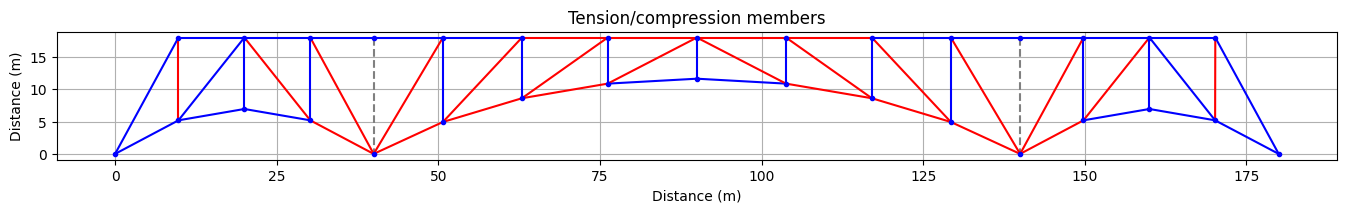

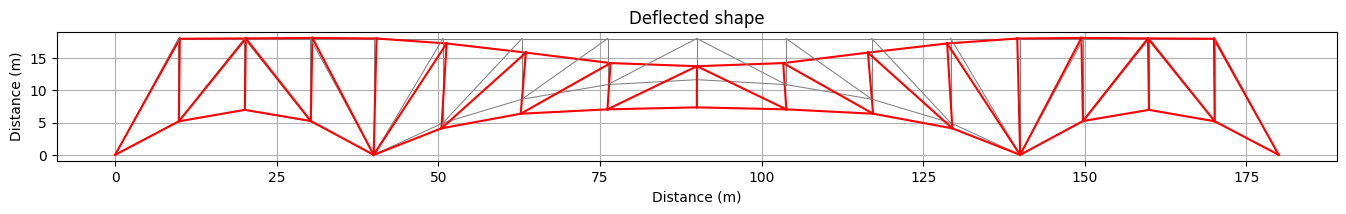

In [37]:
#FIGURE TO PLOT TENSION/COMPRESSION MEMBERS
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for n, mbr in enumerate(members):
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member

    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member

    if(abs(mbrForces[n])<0.001):
        axes.plot([ix,jx],[iy,jy],'grey',linestyle='--') #Zero force in member
    elif(mbrForces[n]>0):
        axes.plot([ix,jx],[iy,jy],'b') #Member in tension
    else:
        axes.plot([ix,jx],[iy,jy],'r') #Member in compression

#Plot nodes
for node in nodes:
    axes.plot([node[0]],[node[1]],'bo', ms=3)

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Tension/compression members')
axes.grid()
plt.show()

#=========================================================================

#FIGURE TO PLOT DEFLECTED SHAPE
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal', adjustable='box')

#Plot members
for mbr in members:
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ix = nodes[node_i-1,0] #x-coord of node i of this member
    iy = nodes[node_i-1,1] #y-coord of node i of this member
    jx = nodes[node_j-1,0] #x-coord of node j of this member
    jy = nodes[node_j-1,1] #y-coord of node j of this member

    #Index of DoF for this member
    ia = 2*node_i-2 #horizontal DoF at node i of this member
    ib = 2*node_i-1 #vertical DoF at node i of this member
    ja = 2*node_j-2 #horizontal DoF at node j of this member
    jb = 2*node_j-1 #vertical DoF at node j of this member

    axes.plot([ix,jx],[iy,jy],'grey', lw=0.75) #Member
    axes.plot([ix + UG[ia,0]*xFac, jx + UG[ja,0]*xFac], [iy + UG[ib,0]*xFac, jy + UG[jb,0]*xFac],'r') #Deformed member

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Deflected shape')
axes.grid()
plt.show()


## Summary output

In [38]:
#Generate output statements
print("REACTIONS")
for i in np.arange(0,len(restrainedIndex)):
    index = restrainedIndex[i]
    print("Reaction at DoF {one}: {two} kN".format(one = index+1, two = round(FG[index].item()/1000,2)))

print("")
print("MEMBER FORCES")
for n, mbr in enumerate(members):
    print("Force in member {one} (nodes {two} to {three}) is {four} kN".format(one = n+1, two=mbr[0], three=mbr[1], four=round(mbrForces[n]/1000,2)))

print("")
print("NODAL DISPLACEMENTS")
for n, node in enumerate(nodes):
    ix = 2*(n+1)-2 #horizontal DoF for this node
    iy = 2*(n+1)-1 #vertical DoF for this node

    ux = round(UG[ix,0],5) #Horizontal nodal displacement
    uy = round(UG[iy,0],5) #Vertical nodal displacement
    print("Node {one}: Ux = {two}, Uy = {three}".format(one=n+1, two=ux, three=uy))

REACTIONS
Reaction at DoF 1: -125.01 kN
Reaction at DoF 2: -107.21 kN
Reaction at DoF 33: 125.08 kN
Reaction at DoF 34: -107.24 kN
Reaction at DoF 41: -931.49 kN
Reaction at DoF 42: 807.22 kN
Reaction at DoF 57: 931.42 kN
Reaction at DoF 58: 807.22 kN

MEMBER FORCES
Force in member 1 (nodes 1 to 2) is 65.6 kN
Force in member 2 (nodes 2 to 3) is 31.38 kN
Force in member 3 (nodes 3 to 4) is 202.09 kN
Force in member 4 (nodes 4 to 5) is 238.24 kN
Force in member 5 (nodes 5 to 6) is 238.24 kN
Force in member 6 (nodes 6 to 7) is 59.0 kN
Force in member 7 (nodes 7 to 8) is -253.58 kN
Force in member 8 (nodes 8 to 9) is -636.51 kN
Force in member 9 (nodes 9 to 10) is -636.65 kN
Force in member 10 (nodes 10 to 11) is -253.56 kN
Force in member 11 (nodes 11 to 12) is 58.84 kN
Force in member 12 (nodes 12 to 13) is 238.3 kN
Force in member 13 (nodes 13 to 14) is 238.3 kN
Force in member 14 (nodes 14 to 15) is 202.16 kN
Force in member 15 (nodes 15 to 16) is 31.67 kN
Force in member 16 (nodes 16 